In [4]:
# # if used pip install package
# !pip install xgboost
# !pip install lightgbm
# !pip install wget
# !pip install gensim

In [5]:
import os
import sys
import gc
import wget
import time
import tarfile
import zipfile
import random
import copy
from tqdm import tqdm_notebook, tqdm

import scipy
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD

import gensim
import xgboost as xgb
import lightgbm as lgb

from joblib import Parallel, delayed

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
DDIR = "data"
UDDIR = "user_data"
UFEDIR = "user_data/feat_data_v04"
UMDIR = "user_data/model_data"
RESDIR = "prediction_result"

In [7]:
UID = "user_id"

# Load data (Only once)

In [ ]:
# train_fname = wget.download("https://tesla-ap-shanghai-1256322946.cos.ap-shanghai.myqcloud.com/cephfs/tesla_common/deeplearning/dataset/algo_contest/train_preliminary.zip", out=DDIR)
# test_fname = wget.download("https://tesla-ap-shanghai-1256322946.cos.ap-shanghai.myqcloud.com/cephfs/tesla_common/deeplearning/dataset/algo_contest/test.zip", out=DDIR)

In [ ]:
# def myunzip(filename):
#     zFile = zipfile.ZipFile(filename, "r")
#     for fileM in zFile.namelist(): 
#         zFile.extract(fileM, DDIR)
#         print(fileM)
#     zFile.close()

In [ ]:
# myunzip(train_fname)
# myunzip(test_fname)

# Utils

In [ ]:
def bch_rencol(values, prefix="", suffix=""):
    return list(map(lambda x: f"{prefix}"+"_".join(list(map(lambda y: str(y), x)))+f"{suffix}" 
                    if hasattr(x, "__iter__") and not isinstance(x, str) 
                    else f"{prefix}"+str(x)+f"{suffix}", values))

In [ ]:
def mynunique(values):
    return values.nunique(dropna=False)

In [ ]:
def getidxmax(x):
    return x.idxmax()[1]

In [ ]:
# for time series
def at_len(x):
    return len(x)

def at_sum(x):
    return np.sum(x)

def at_max(x):
    return np.max(x)

def at_min(x):
    return np.min(x)

def at_mean(x):
    return np.mean(x)

def at_range(x):
    return at_max(x) - at_min(x)

def at_nunq(x):
    return len(set(x))

def at_lenDrange(x):
    return at_len(x)/(at_range(x)+1)

def at_lenDnunq(x):
    return at_len(x)/at_nunq(x)

def at_percentile(n):
    def at_percentile_(x):
        return np.percentile(x, n)
    at_percentile_.__name__ = f"at_percentile_{n}"
    return at_percentile_


In [ ]:
OP_SET = ["sum", "max", "min", "mean", "std", getidxmax, "nunique"]

# Data Exploration (todo)

In [ ]:
# read train data
train_click_log = pd.read_csv(f"{DDIR}/train_preliminary/click_log.csv")
train_ad = pd.read_csv(f"{DDIR}/train_preliminary/ad.csv")
# tag
train_user = pd.read_csv(f"{DDIR}/train_preliminary/user.csv")

In [ ]:
# read test data
test_click_log = pd.read_csv(f"{DDIR}/test/click_log.csv")
test_ad = pd.read_csv(f"{DDIR}/test/ad.csv")

In [ ]:
train_click_log.shape

In [ ]:
train_ad.shape

In [ ]:
train_user.shape

In [ ]:
test_click_log.shape

In [ ]:
test_ad.shape

In [ ]:
train_ad["product_id"] = train_ad["product_id"].replace("\\N", -1).astype(int)
train_ad["industry"] = train_ad["industry"].replace("\\N", -1).astype(int)

In [ ]:
test_ad["product_id"] = test_ad["product_id"].replace("\\N", -1).astype(int)
test_ad["industry"] = test_ad["industry"].replace("\\N", -1).astype(int)

In [ ]:
# creative id in train (creative id is unique in train_ad)
len(train_ad)

In [ ]:
# creative id in test (creative id is unique in test_ad)
len(test_ad)

In [ ]:
# check whether the same creative_id in train and test have same ad info
insect1d = np.intersect1d(train_click_log.creative_id.unique(), test_click_log.creative_id.unique())
print("Same creative id: ", insect1d.shape)
print("Diff number: ", np.sum(train_ad[train_ad.creative_id.isin(insect1d)].values != test_ad[test_ad.creative_id.isin(insect1d)].values))
# checked: they all have same ad info (result is 0)

In [ ]:
# check whether click and ad have diff creative_id
print("Diff list: ", np.setdiff1d(train_click_log.creative_id.unique(), train_ad.creative_id))
print("Diff list: ", np.setdiff1d(train_ad.creative_id, train_click_log.creative_id.unique()))

In [ ]:
# check whether click and ad have diff creative_id
print("Diff list: ", np.setdiff1d(test_click_log.creative_id.unique(), test_ad.creative_id))
print("Diff list: ", np.setdiff1d(test_ad.creative_id, test_click_log.creative_id.unique()))

In [ ]:
# click time
sns.lineplot(x=train_click_log.time.value_counts().index, y=train_click_log.time.value_counts())

In [ ]:
sns.lineplot(x=test_click_log.time.value_counts().index, y=test_click_log.time.value_counts())

In [ ]:
# data_grouped = data.groupby(data.index)
# results = Parallel(n_jobs=8)(delayed(key_func)(group) for name, group in data_grouped)
# data = pd.concat(results)

# Feature engineering

In [ ]:
# Edit
train_click_log.sort_values(by="time", inplace=True)
test_click_log.sort_values(by="time", inplace=True)

In [ ]:
tol_train = pd.merge(train_click_log, train_ad, how="left", on="creative_id")
tol_test = pd.merge(test_click_log, test_ad, how="left", on="creative_id")

In [ ]:
del train_click_log, train_ad
del test_click_log, test_ad

In [ ]:
# tol_data = pd.concat([tol_train, tol_test]).sort_values(by="time").reset_index(drop=True)
# pd.DataFrame(np.sort(tol_test[UID].unique()), columns=[UID]).to_csv(f"{DDIR}/test/user.csv", index=False)
# tol_data.to_csv(f"{DDIR}/tol_data.csv", index=False)

In [ ]:
# tmp = tol_train.groupby([UID], sort=False)[["creative_id", "ad_id"]].agg(lambda x: [f"word_{y}" for y in x])
# tmp.columns = bch_rencol(tmp.columns)
# tmp.to_pickle(f"{UDDIR}/imd/train_cidnaid_seq.pkl")
# tmp = None

In [ ]:
# tmp = tol_test.groupby([UID], sort=False)[["creative_id", "ad_id"]].agg(lambda x: [f"word_{y}" for y in x])
# tmp.columns = bch_rencol(tmp.columns)
# tmp.to_pickle(f"{UDDIR}/imd/test_cidnaid_seq.pkl")
# tmp = None

## Sequence features

In [ ]:
train_cidnaid_seq = pd.read_pickle(f"{UDDIR}/imd/train_cidnaid_seq.pkl")
test_cidnaid_seq = pd.read_pickle(f"{UDDIR}/imd/test_cidnaid_seq.pkl")

In [ ]:
tol_cidnaid_seq = pd.concat([train_cidnaid_seq, test_cidnaid_seq])

In [ ]:
tol_cidnaid_seq["creative_id"] = tol_cidnaid_seq["creative_id"].apply(lambda x: " ".join(x))
tol_cidnaid_seq["ad_id"] = tol_cidnaid_seq["ad_id"].apply(lambda x: " ".join(x))

In [ ]:
del train_cidnaid_seq, test_cidnaid_seq
gc.collect()

In [ ]:
tfidf_enc = TfidfVectorizer(ngram_range=(1, 2), max_df=0.6)

In [ ]:
tfidf_vec = tfidf_enc.fit_transform(tol_cidnaid_seq["ad_id"].values)

In [ ]:
tfidf_vec.shape

In [ ]:
scipy.sparse.save_npz(f"{UDDIR}/imd/sparse_ad_id.npz", tfidf_vec)
# tmp = scipy.sparse.load_npz(f"{UDDIR}/imd/sparse_creative_id.npz")

In [ ]:
tfidf_vec = scipy.sparse.load_npz(f"{UDDIR}/imd/sparse_creative_id.npz")

In [ ]:
ncpt = 128
svd_enc = TruncatedSVD(n_components=ncpt, n_iter=20, random_state=2020)
mode_svd = svd_enc.fit_transform(tfidf_vec)
mode_svd = pd.DataFrame(mode_svd)
mode_svd.columns = ['svd_ad_id_{}'.format(i) for i in range(ncpt)]

In [ ]:
gc.collect()

In [ ]:
help(TfidfVectorizer)

## Word2Vec

In [ ]:
train_cidnaid_seq = pd.read_pickle(f"{UDDIR}/imd/train_cidnaid_seq.pkl")
test_cidnaid_seq = pd.read_pickle(f"{UDDIR}/imd/test_cidnaid_seq.pkl")

In [ ]:
tol_cidnaid_seq = pd.concat([train_cidnaid_seq, test_cidnaid_seq])

In [ ]:
vector_size = 128

In [ ]:
model = gensim.models.Word2Vec(sentences=tol_cidnaid_seq["creative_id"], size=vector_size, window=5, min_count=5, workers=12, sg=0, iter=10)

In [ ]:
model.save(f"{UMDIR}/w2v_creative_id.model")

In [ ]:
creative_id_w2v = list()

In [ ]:
for col in tqdm(tol_cidnaid_seq["creative_id"]):
    tmp = np.zeros(vector_size)
    for wd in col:
        if wd in model:
            tmp += model[wd]
    creative_id_w2v.append(list(tmp))

In [ ]:
cum_creative_id_w2v = pd.DataFrame(creative_id_w2v)

In [ ]:
cum_creative_id_w2v.index = tol_cidnaid_seq.index

In [ ]:
cum_creative_id_w2v.to_pickle(f"{UFEDIR}/cum_creative_id_w2v.pkl")

In [ ]:
wv = model.wv
vocab_list = wv.index2word
word_idx_dict = {}
for idx, word in enumerate(vocab_list):
    word_idx_dict[word] = idx
    
vectors_arr = wv.vectors
vectors_arr = np.concatenate((np.zeros(vector_size)[np.newaxis, :], vectors_arr), axis=0)#第0位置的vector为'unk'的vector

In [ ]:
# wv = model.wv
# vocab_list = wv.index2word
# word_idx_dict = {}
# for idx, word in enumerate(vocab_list):
#     word_idx_dict[word] = idx
    
# vectors_arr = wv.vectors
# vectors_arr = np.concatenate((np.zeros(vector_size)[np.newaxis, :], vectors_arr), axis=0)#第0位置的vector为'unk'的vector

# f_wordidx = open(feature_path + 'word_seg_word_idx_dict.pkl', 'wb')
# f_vectors = open(feature_path + 'word_seg_vectors_arr.pkl', 'wb')
# pickle.dump(word_idx_dict, f_wordidx)
# pickle.dump(vectors_arr, f_vectors)
# f_wordidx.close()
# f_vectors.close()

## Creative id map (bad)

In [ ]:
train_ucid = pd.merge(tol_train[[UID, "creative_id"]], train_user, how="left", on=UID)

In [ ]:
cid_map = train_ucid.groupby(["creative_id"])[["age", "gender"]].agg(["mean"])
cid_map.columns = bch_rencol(cid_map.columns, prefix="creative_id_")

In [ ]:
cid_map.drop(np.setdiff1d(tol_train["creative_id"].unique(), tol_test["creative_id"].unique()), inplace=True)

In [ ]:
tol_train = pd.merge(tol_train, cid_map, how="left", on="creative_id")

In [ ]:
tol_test = pd.merge(tol_test, cid_map, how="left", on="creative_id")

In [ ]:
tol_test.shape

In [ ]:
tol_train.shape

In [ ]:
del cid_map

In [ ]:
tmp = tol_train.groupby([UID])["creative_id_age_mean", "creative_id_gender_mean"].agg(["sum", "max", "mean", "min", "std"])
tmp.columns = bch_rencol(tmp.columns)

In [ ]:
tmp.to_pickle(f"{UFEDIR}/train_o1_cid_map.pkl")
tmp = None

In [ ]:
tmp = tol_test.groupby([UID])["creative_id_age_mean", "creative_id_gender_mean"].agg(["sum", "max", "mean", "min", "std"])
tmp.columns = bch_rencol(tmp.columns)

In [ ]:
tmp.to_pickle(f"{UFEDIR}/test_o1_cid_map.pkl")
tmp = None

## User Click log (Order 1)

In [ ]:
ops_dic = {
        UID: ["count"], 
        "click_times": ["sum", "max", "mean", "std", at_nunq, at_range, at_lenDnunq, at_lenDrange, at_percentile(.75), at_percentile(.25)],
        "time": ["nunique", "mean", "max", "min", at_range, at_lenDnunq, at_lenDrange, at_percentile(.75), at_percentile(.25)],
        "creative_id": ["nunique", at_lenDnunq],
        "ad_id": ["nunique", at_lenDnunq],
        "product_id": ["nunique", at_lenDnunq],
        "product_category": ["nunique", at_lenDnunq],
        "advertiser_id": ["nunique", at_lenDnunq],
        "industry": ["nunique", at_lenDnunq],
}

In [ ]:
for col in ops_dic:
    tmp = tol_train.groupby([UID], sort=False)[[col]].agg(ops_dic[col])
    tmp.columns = bch_rencol(tmp.columns)
    tmp.to_pickle(f"{UFEDIR}/train_o1_{col}.pkl")
    tmp = None

In [ ]:
for col in ops_dic:
    tmp = tol_test.groupby([UID], sort=False)[[col]].agg(ops_dic[col])
    tmp.columns = bch_rencol(tmp.columns)
    tmp.to_pickle(f"{UFEDIR}/test_o1_{col}.pkl")
    tmp = None

In [ ]:
tmp = tol_train.groupby([UID, "time"], sort=False)[["creative_id", "ad_id", "product_id", "product_category", "advertiser_id", "industry"]].agg(["nunique", at_lenDnunq])\
.groupby([UID]).agg(["sum", "max", "min", "mean", "std"])
tmp.columns = bch_rencol(tmp.columns)
tmp.to_pickle(f"{UFEDIR}/train_o1_time2columns.pkl")
tmp = None

In [ ]:
tmp = tol_test.groupby([UID, "time"], sort=False)[["creative_id", "ad_id", "product_id", "product_category", "advertiser_id", "industry"]].agg(["nunique", at_lenDnunq])\
.groupby([UID]).agg(["sum", "max", "min", "mean", "std"])
tmp.columns = bch_rencol(tmp.columns)
tmp.to_pickle(f"{UFEDIR}/test_o1_time2columns.pkl")
tmp = None

In [ ]:
tmp = pd.read_pickle(f"{UFEDIR}/test_o1_time2columns.pkl")

In [ ]:
tmp.columns = bch_rencol(tmp.columns)

In [ ]:
tmp.to_pickle(f"{UFEDIR}/test_o1_time2columns.pkl")

In [ ]:
# # # before features v03
# # for train
# tmp = tol_train.groupby([UID], sort=False).agg(
#     {
#         UID: ["count"], 
#         "click_times": ["sum", "max", "mean", "std"],
#         "time": ["nunique", "mean", "max", "min"],
#         "creative_id": ["nunique"],
#         "ad_id": ["nunique"],
#         "product_id": ["nunique"],
#         "product_category": ["nunique"],
#         "advertiser_id": ["nunique"],
#         "industry": ["nunique"],
#     }
# )

In [ ]:
# # # before features v03
# tmp.columns = bch_rencol(tmp.columns)
# tmp.to_pickle(f"{UFEDIR}/train_o1.pkl")
# tmp = None

In [ ]:
# # # before features v03
# # for test
# tmp = tol_test.groupby([UID], sort=False).agg(
#     {
#         UID: ["count"], 
#         "click_times": ["sum", "max", "mean", "std"],
#         "time": ["nunique", "mean", "max", "min"],
#         "creative_id": ["nunique"],
#         "ad_id": ["nunique"],
#         "product_id": ["nunique"],
#         "product_category": ["nunique"],
#         "advertiser_id": ["nunique"],
#         "industry": ["nunique"],
#     }
# )

In [ ]:
# # # before features v03
# tmp.columns = bch_rencol(tmp.columns)
# tmp.to_pickle(f"{UFEDIR}/test_o1.pkl")
# tmp = None

In [ ]:
gc.collect()

## User Click log (Order 2)

In [ ]:
o2_ops_dic = {
    "click_times": ["sum", "max", "mean", "std", at_nunq, at_range, at_lenDnunq, at_lenDrange, at_percentile(.75), at_percentile(.25)],
    "time": ["nunique", "mean", "max", "min", at_range, at_lenDnunq, at_lenDrange, at_percentile(.75), at_percentile(.25)],
}

In [ ]:
hold_cols = ["creative_id", "ad_id", "product_id", "product_category", "advertiser_id", "industry"]

In [ ]:
# feature v03
for col in hold_cols:
    tmp = tol_train.groupby([UID, col], sort=False)[[col]].agg(["count"]).groupby([UID]).agg(OP_SET)
    tmp.columns = bch_rencol(tmp.columns)
    tmp.to_pickle(f"{UFEDIR}/train_o2_{col}2{col}.pkl")
    tmp = None
    for ocol in o2_ops_dic:
        tmp = tol_train.groupby([UID, col], sort=False)[[ocol]].agg(o2_ops_dic[ocol]).groupby([UID]).agg(["sum", "max", "min", "mean", "std"])
        tmp.columns = bch_rencol(tmp.columns)
        tmp.to_pickle(f"{UFEDIR}/train_o2_{col}2{ocol}.pkl")
        tmp = None

In [ ]:
# feature v03
for col in hold_cols:
    tmp = tol_test.groupby([UID, col], sort=False)[[col]].agg(["count"]).groupby([UID]).agg(OP_SET)
    tmp.columns = bch_rencol(tmp.columns)
    tmp.to_pickle(f"{UFEDIR}/test_o2_{col}2{col}.pkl")
    tmp = None
    for ocol in o2_ops_dic:
        tmp = tol_test.groupby([UID, col], sort=False)[[ocol]].agg(o2_ops_dic[ocol]).groupby([UID]).agg(["sum", "max", "min", "mean", "std"])
        tmp.columns = bch_rencol(tmp.columns)
        tmp.to_pickle(f"{UFEDIR}/test_o2_{col}2{ocol}.pkl")
        tmp = None

In [ ]:
# # # before v03
# # train
# for col in ["creative_id", "ad_id", "product_id", "product_category", "advertiser_id", "industry"]:
#     tmp = tol_train.groupby([UID, col], sort=False)[[col]].agg(["count"]).groupby([UID]).agg(OP_SET)
#     tmp.columns = bch_rencol(tmp.columns)
#     tmp.to_pickle(f"{UFEDIR}/train_o2_{col}.pkl")
#     tmp = None

In [ ]:
# # # before v03
# # test
# for col in ["creative_id", "ad_id", "product_id", "product_category", "advertiser_id", "industry"]:
#     tmp = tol_test.groupby([UID, col], sort=False)[[col]].agg(["count"]).groupby([UID]).agg(OP_SET)
#     tmp.columns = bch_rencol(tmp.columns)
#     tmp.to_pickle(f"{UFEDIR}/test_o2_{col}.pkl")
#     tmp = None

In [ ]:
gc.collect()

## One-Hot

In [ ]:
# train
tmp = tol_train.groupby([UID, "product_category"], sort=False)[["product_category"]].agg(["count"]).unstack().fillna(0)
tmp.columns = bch_rencol(tmp.columns)

In [ ]:
tmp.to_pickle(f"{UFEDIR}/train_onehot.pkl")
tmp = None

In [ ]:
# test
tmp = tol_test.groupby([UID, "product_category"], sort=False)[["product_category"]].agg(["count"]).unstack().fillna(0)
tmp.columns = bch_rencol(tmp.columns)

In [ ]:
tmp.to_pickle(f"{UFEDIR}/test_onehot.pkl")
tmp = None

In [ ]:
gc.collect()

## Time Windows (Time Bins)

In [ ]:
bins = 9
tol_bins = pd.cut(pd.concat([tol_train["time"], tol_test["time"]]), bins, labels=range(bins))

In [ ]:
tol_train[f"bins{bins}"] = tol_bins[:len(tol_train)]
tol_test[f"bins{bins}"] = tol_bins[len(tol_train):]

In [ ]:
tol_train.

### Order 1

In [ ]:
# train
tmp = tol_train.groupby([UID, f"bins{bins}"], sort=False).agg(
    {
        UID: ["count"], 
        "click_times": ["sum", "max", "mean", "std"],
        "time": ["nunique", "mean", "max", "min"],
        "creative_id": ["nunique"],
        "ad_id": ["nunique"],
        "product_id": ["nunique"],
        "product_category": ["nunique"],
        "advertiser_id": ["nunique"],
        "industry": ["nunique"],
    }
).unstack()

In [ ]:
tmp.columns = bch_rencol(tmp.columns, prefix=f"bins{bins}_")

In [ ]:
tmp.to_pickle(f"{UFEDIR}/train_bins{bins}_o1.pkl")
tmp = None

In [ ]:
# test
tmp = tol_test.groupby([UID, f"bins{bins}"], sort=False).agg(
    {
        UID: ["count"], 
        "click_times": ["sum", "max", "mean", "std"],
        "time": ["nunique", "mean", "max", "min"],
        "creative_id": ["nunique"],
        "ad_id": ["nunique"],
        "product_id": ["nunique"],
        "product_category": ["nunique"],
        "advertiser_id": ["nunique"],
        "industry": ["nunique"],
    }
).unstack()

In [ ]:
tmp.columns = bch_rencol(tmp.columns, prefix=f"bins{bins}_")

In [ ]:
tmp.to_pickle(f"{UFEDIR}/test_bins{bins}_o1.pkl")
tmp = None

In [ ]:
gc.collect()

### Order 2

In [ ]:
# train
for col in ["creative_id", "ad_id", "product_id", "product_category", "advertiser_id", "industry"]:
    for i in range(bins):
        tmp = tol_train[tol_train[f"bins{bins}"] == i].groupby([UID, col], sort=False)[[col]].agg(["count"]).groupby([UID]).agg(OP_SET)
        tmp.columns = bch_rencol(tmp.columns, prefix=f"bins{bins}_{i}_")
        tmp.to_pickle(f"{UFEDIR}/train_bins{bins}_{i}_o2_{col}.pkl")
        tmp = None

In [ ]:
# test
for col in ["creative_id", "ad_id", "product_id", "product_category", "advertiser_id", "industry"]:
    for i in range(bins):
        tmp = tol_test[tol_test[f"bins{bins}"] == i].groupby([UID, col], sort=False)[[col]].agg(["count"]).groupby([UID]).agg(OP_SET)
        tmp.columns = bch_rencol(tmp.columns, prefix=f"bins{bins}_{i}_")
        tmp.to_pickle(f"{UFEDIR}/test_bins{bins}_{i}_o2_{col}.pkl")
        tmp = None

In [ ]:
gc.collect()

## Conact

In [68]:
train_user = pd.read_csv(f"{DDIR}/train_preliminary/user.csv")
test_user = pd.read_csv(f"{DDIR}/test/user.csv")

In [69]:
train_feat = pd.DataFrame()
test_feat = pd.DataFrame()
train_feat[UID] = train_user[UID]
test_feat[UID] = test_user[UID]

In [70]:
cum_creative_id_w2v = pd.read_pickle(f"{UFEDIR}/cum_creative_id_w2v.pkl")

In [71]:
train_feat = pd.merge(train_feat, cum_creative_id_w2v, how="left", on=UID)
test_feat = pd.merge(test_feat, cum_creative_id_w2v, how="left", on=UID)

In [72]:
feat_fname = os.listdir(UFEDIR)

In [73]:
for fname in feat_fname:
    if fname.startswith("train_"):
        train_feat = pd.merge(train_feat, pd.read_pickle(f"{UFEDIR}/{fname}"), how="left", on=UID)
    elif fname.startswith("test_"):
        test_feat = pd.merge(test_feat, pd.read_pickle(f"{UFEDIR}/{fname}"), how="left", on=UID)

In [74]:
# to make sure feat and user(target) have same order
# if true --> sum == 0
np.sum(train_feat[UID] != train_user[UID])

0

In [75]:
train_feat.shape

(900000, 161)

In [76]:
test_feat.shape

(1000000, 161)

In [ ]:
# del tol_test

In [77]:
gc.collect()

88

In [ ]:
train_feat.to_pickle(f"{UDDIR}/feat_ing/train_feat_tol_v02.pkl")
test_feat.to_pickle(f"{UDDIR}/feat_ing/test_feat_tol_v02.pkl")

In [ ]:
train_feat = pd.read_pickle(f"{UDDIR}/feat_ing/train_feat_tol_v02.pkl")
test_feat = pd.read_pickle(f"{UDDIR}/feat_ing/test_feat_tol_v02.pkl")
train_user = pd.read_csv(f"{DDIR}/train_preliminary/user.csv")

In [ ]:
train_feat.shape

In [ ]:
# train_feat.drop([col for col in train_feat.columns if col.find("creative_id_gender_") != -1], axis=1, inplace=True)

In [ ]:
# test_feat.drop([col for col in test_feat.columns if col.find("creative_id_gender_") != -1], axis=1, inplace=True)

In [ ]:
# list(train_feat.columns)

In [ ]:
# train_feat["industry_count_getidxmax"] = train_feat["industry_count_getidxmax"].replace("\\N", -1).astype(float)
# train_feat["product_id_count_getidxmax"] = train_feat["product_id_count_getidxmax"].replace("\\N", -1).astype(float)
# test_feat["industry_count_getidxmax"] = test_feat["industry_count_getidxmax"].replace("\\N", -1).astype(float)
# test_feat["product_id_count_getidxmax"] = test_feat["product_id_count_getidxmax"].replace("\\N", -1).astype(float)

# Training&Prediction

In [78]:
# split data
train_feat_tr, train_feat_val, train_tag_tr, train_tag_val = train_test_split(train_feat, train_user, test_size=0.2, random_state=2020)

In [79]:
train_feat.drop(UID, axis=1, inplace=True)

In [80]:
train_feat_tr.drop(UID, axis=1, inplace=True)

In [81]:
train_feat_val.drop(UID, axis=1, inplace=True)

In [82]:
gc.collect()

10

## For Age

In [83]:
lgbds_train_tr_age = lgb.Dataset(train_feat_tr, train_tag_tr["age"]-1)
lgbds_train_val_age = lgb.Dataset(train_feat_val, train_tag_val["age"]-1)

In [84]:
params_age = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "num_class": 10,
    "metric": "multi_error",
    "learning_rate": 0.1,
    "seed": 2020,
    "n_jobs": -1,
}

In [ ]:
model_lgb_multi_age_off = lgb.train(params_age, lgbds_train_tr_age, num_boost_round=1000, valid_sets=[lgbds_train_val_age], verbose_eval=50, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
[50]	valid_0's multi_error: 0.679678


In [ ]:
[50]	valid_0's multi_error: 0.678856
[100]	valid_0's multi_error: 0.665433

In [ ]:
train_val_age_prob = model_lgb_multi_age_off.predict(train_feat_val, num_iteration=model_lgb_multi_age_off.best_iteration)
train_val_age_pred = [list(x).index(max(x))+1 for x in train_val_age_prob]
age_acy = accuracy_score(train_val_age_pred, train_tag_val["age"])

In [27]:
# online
lgbds_train_age = lgb.Dataset(train_feat, train_user["age"]-1)

In [ ]:
model_lgb_multi_age = lgb.train(params_age, lgbds_train_age, num_boost_round=500, verbose_eval=50)

In [ ]:
ndt = time.strftime("%Y%m%d%H%M%S", time.localtime(int(time.time())))
model_lgb_multi_age.save_model(f"{UMDIR}/lgb_multi_age_{ndt}.model")

In [ ]:
# Online 

## For Gender

In [ ]:
lgbds_train_tr_gender = lgb.Dataset(train_feat_tr, train_tag_tr["gender"]-1)
lgbds_train_val_gender = lgb.Dataset(train_feat_val, train_tag_val["gender"]-1)

In [ ]:
params_gender = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "num_class": 2,
    "metric": "multi_error",
    "learning_rate": 0.1,
    "seed": 2020,
    "n_jobs": -1,
}

In [ ]:
model_lgb_multi_gender_off = lgb.train(params_gender, lgbds_train_tr_gender, num_boost_round=1000, valid_sets=[lgbds_train_val_gender], verbose_eval=50, early_stopping_rounds=100)

In [ ]:
train_val_gender_prob = model_lgb_multi_gender_off.predict(train_feat_val, num_iteration=model_lgb_multi_gender_off.best_iteration)
train_val_gender_pred = [list(x).index(max(x))+1 for x in train_val_gender_prob]
gender_acy = accuracy_score(train_val_gender_pred, train_tag_val["gender"])

In [ ]:
# online
lgbds_train_gender = lgb.Dataset(train_feat, train_user["gender"]-1)

In [ ]:
model_lgb_multi_gender = lgb.train(params_gender, lgbds_train_gender, num_boost_round=500, verbose_eval=50)

In [ ]:
ndt = time.strftime("%Y%m%d%H%M%S", time.localtime(int(time.time())))
model_lgb_multi_gender.save_model(f"{UMDIR}/lgb_multi_gender_{ndt}.model")

In [ ]:
# total accuracy
age_acy + gender_acy

# Generate Prediction Result

In [ ]:
# model_lgb_multi_age = lgb.Booster(model_file=f"{UMDIR}/lgb_multi_age_20200511045531.model")

In [ ]:
# model_lgb_multi_gender = lgb.Booster(model_file=f"{UMDIR}/lgb_multi_gender_20200511034408.model")

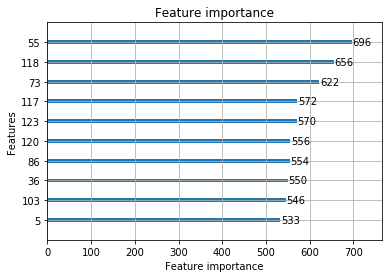

In [34]:
lgb.plot_importance(model_lgb_multi_gender, max_num_features=10)

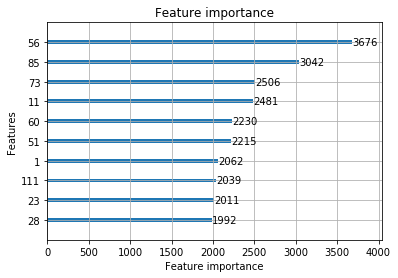

In [35]:
lgb.plot_importance(model_lgb_multi_age, max_num_features=10)

In [36]:
res = test_feat[[UID]]

In [37]:
test_feat.drop(UID, axis=1, inplace=True)

In [38]:
res["predicted_age"] = [list(x).index(max(x))+1 for x in model_lgb_multi_age.predict(test_feat, num_iteration=model_lgb_multi_age.best_iteration)]

/opt/conda/envs/tensorflow_py3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [39]:
res["predicted_gender"] = [list(x).index(max(x))+1 for x in model_lgb_multi_gender.predict(test_feat, num_iteration=model_lgb_multi_gender.best_iteration)]

/opt/conda/envs/tensorflow_py3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [40]:
res_suffix = time.strftime("%Y%m%d%H%M%S", time.localtime(int(time.time())))
res.to_csv(f"{RESDIR}/res-{res_suffix}.csv", index=False)

In [41]:
res["predicted_age"].value_counts()

3     348514
2     149532
5     142403
4     125507
6     120056
7      48097
1      20530
8      17937
9      15974
10     11450
Name: predicted_age, dtype: int64

In [42]:
res["predicted_gender"].value_counts()

1    681469
2    318531
Name: predicted_gender, dtype: int64

# Cent result to COS

In [43]:
from ti import session
ti_session = session.Session()

In [44]:
inputs = ti_session.upload_data(path=f"{RESDIR}/res-20200513115853.csv", bucket="etveritas-1252104022", key_prefix=RESDIR)